<a href="https://colab.research.google.com/gist/qbeer/07eb98879a555a676b6da86ea8cd7f9e/hw_6_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import metrics

/Users/barnabasp/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


https://datasetsearch.research.google.com/search?query=leopards&docid=L2cvMTFqOWMya244eg%3D%3D

## 1. Implement a linear model
return the weight parameters w = (w1, w2, ... , wP) and the intercept parameter w0 separately where:

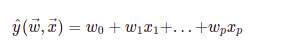

* check your returned coefficients with the built in `LinearRegression` class from the sklearn library, they should be within tolerance 1e-6 to each other

* use a generated regression dataset from `sklearn.dataset import make_regression` API with parameters `n_samples=1000` and `n_features=20`

$\omega = \left(X^T X\right)^{-1}X^T y$

In [127]:
#From the 4th homework, we used an analytical solver, https://docs.google.com/presentation/d/13kZ1kwNrlbuA6B5Ax-YCrjCuN7Db48Ed/edit#slide=id.p10
def analLinRegression(X, y):
    coefs = np.matmul(np.linalg.inv(np.matmul(X.T,X)),np.matmul(X.T,y))
    return coefs
def intercepts(coefs, y, X):
    #y = a*x + b, we need 'b'
    return np.mean(y) - coefs*np.mean(X)

In [6]:
from sklearn.datasets import make_regression

In [114]:
X, y = make_regression(n_samples=1000, n_features=20)

In [126]:
np.mean(X)
np.mean(y)

-0.006145683540627444

In [129]:
reg = LinearRegression().fit(X,y)
print(reg.coef_, reg.intercept_)

[ 7.48659741e+01  4.10059460e+00 -7.49634894e-14  2.05786226e+01
 -1.67305310e-14  2.50671786e-14  6.44082089e+01  5.96256477e+01
  5.94228904e+01  2.44575111e+00 -3.90939722e-14  3.35889756e+01
  5.70922986e-14 -5.30706310e-14 -2.13283852e-14  9.78859900e+01
  3.23522571e-14 -5.95079541e-14  5.72875081e-14  4.03381499e+01] -2.042810365310288e-14


In [110]:
np.abs(analLinRegression(X,y)-reg.coef_) < 1e-6

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [128]:
intercepts(analLinRegression(X,y), y, X)

array([-7.32129187, -7.7561935 , -7.78139446, -7.65492475, -7.78139446,
       -7.78139446, -7.38556199, -7.41495409, -7.41620018, -7.76636364,
       -7.78139446, -7.57496724, -7.78139446, -7.78139446, -7.78139446,
       -7.17981814, -7.78139446, -7.78139446, -7.78139446, -7.53348895])

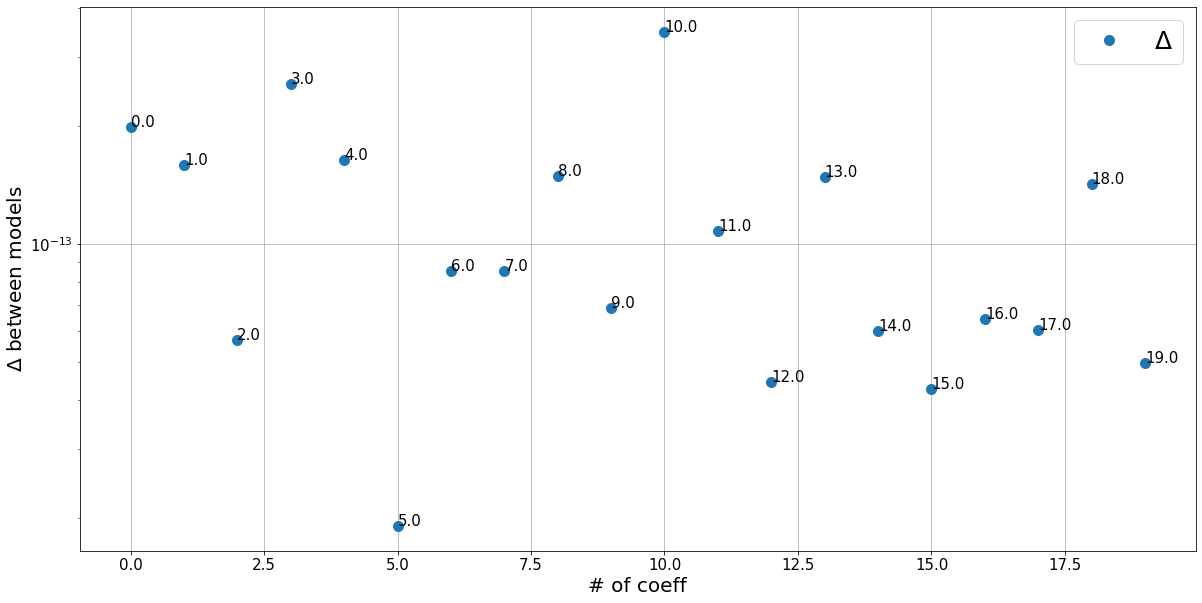

In [72]:
plt.figure(figsize=(20,10))
plt.plot(np.abs(analLinRegression(X,y)-reg.coef_),'o', markersize=10, label=r'$\Delta$')
#plt.plot(reg.coef_,'*', markersize=15)
plt.yscale('log')
#plt.ylim(1e-18, 1e5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(True)
plt.legend(fontsize=25)
plt.xlabel('# of coeff', fontsize=20)
plt.ylabel(r'$\Delta$ between models', fontsize=20)
text=np.linspace(0,19,20)
delta=np.abs(analLinRegression(X,y)-reg.coef_)
for i in range(20):
    plt.annotate(text[i], xy=(text[i],delta[i]),fontsize=15)


## 2. Use of real data

* download the [Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) from UCI, the task includes understanding the dataset: naming the appropiate data fields, handling missing values, etc.

* split the data in training/test sets and fit a LinearRegression model with 5-fold cross-validation on top of it - compare training and testing scores (R^2 by default) for the different CV splits, print the mean score and its standard deviation

* fit the best Lasso regression model with 5-fold grid search cross validation (GridSearchCV) on the parameters: alpha, normalize, max_iter and show the best parameters

## 3. Shrinkage

* interpret Lasso models based on its descriptive parameters by the shrinkage method described during the lecture (make a plot and check the names of the features that are not eliminated by the penalty parameter) on the data we have here [ this is an explanatory data analysis problem, try to be creative ]

* fit Ridge models and apply the shrinkage method as well, did you get what you expect?

* do you think normalization is needed here? if so, do not forget to use it in the next tasks

## 4. Subset selection

* Split the data to training and test sets and do recursice feature elimination until 10 remaining predictors with 5-fold cross-validated regressors (RidgeCV, LassoCV, ElasticNetCV) on the training set, plot their names and look up some of their meanings [ recursive feature elimination is part of sklearn but you can do it with a for loop if you whish ]

* Do all models provide the same descriptors? Check their performance on the test set! Plot all model predictions compared to the y_test on 3 different plots, which model seems to be the best?

# 5. ElasticNet penalty surface
* visualize the surface of the `objective(alpha, beta)`

 * parameters corresponding to the L1 and L2 regularizations. Select the best possible combination of the hyper-parameters that minimize the objective (clue: from scipy.optimize import minimize)

* this task is similar to what you've seen during class, just not for MSE vs. single penalty parameter but MSE vs. two penalty parameters `alpha, beta`

* interpret the overall results, do you think regularization is necessary at all? do you think linear models are powerful enough on this dataset?